In [ ]:
!pip install torch torchvision pillow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os

In [ ]:
from google.colab import files

# Upload content and style images
uploaded = files.upload()


Saving image1.jpeg to image1.jpeg
Saving image2.jpeg to image2.jpeg


In [ ]:
content_path = "image1.jpeg"  # Replace with actual content image filename
style_path = "image2.jpeg"  # Replace with actual style image filename


In [ ]:
print(os.listdir())  # Check if 'content.jpg' and 'style.jpg' exist


['.config', 'image2.jpeg', 'image1.jpeg', 'sample_data']


In [ ]:
# Image preprocessing function
def image_loader(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((400, 400)),  # Resize image
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))  # Scale pixel values
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(torch.float)

content_image = image_loader(content_path)
style_image = image_loader(style_path)


In [ ]:
# Load the pre-trained VGG19 model
cnn = models.vgg19(pretrained=True).features.eval()

# Define layers for content and style extraction
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 169MB/s]


In [ ]:
# Content loss class
class ContentLoss(torch.nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = torch.nn.functional.mse_loss(input, self.target)
        return input


In [ ]:
# Style loss class
class StyleLoss(torch.nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target).detach()

    def gram_matrix(self, input):
        _, c, h, w = input.size()
        features = input.view(c, h * w)
        return torch.mm(features, features.t()) / (c * h * w)

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = torch.nn.functional.mse_loss(G, self.target)
        return input


In [ ]:
def build_model(cnn, content_image, style_image):
    model = torch.nn.Sequential()
    content_losses = []
    style_losses = []

    i = 0  # Counter for layers
    for layer in cnn.children():
        if isinstance(layer, torch.nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, torch.nn.ReLU):
            name = f"relu_{i}"
            layer = torch.nn.ReLU(inplace=False)  # Avoid modifying original ReLU
        elif isinstance(layer, torch.nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, torch.nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_image).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    return model, content_losses, style_losses


Step 0/150 | Content Loss: 0.2537 | Style Loss: 0.3735
Step 20/150 | Content Loss: 0.7444 | Style Loss: 0.9660
Step 40/150 | Content Loss: 0.6637 | Style Loss: 0.8239
Step 60/150 | Content Loss: 0.4480 | Style Loss: 0.8207
Step 80/150 | Content Loss: 0.1220 | Style Loss: 0.5717
Step 100/150 | Content Loss: 0.2855 | Style Loss: 0.8795
Step 120/150 | Content Loss: 0.3616 | Style Loss: 0.3210
Step 140/150 | Content Loss: 1.0000 | Style Loss: 0.3654
✅ Style transfer completed!


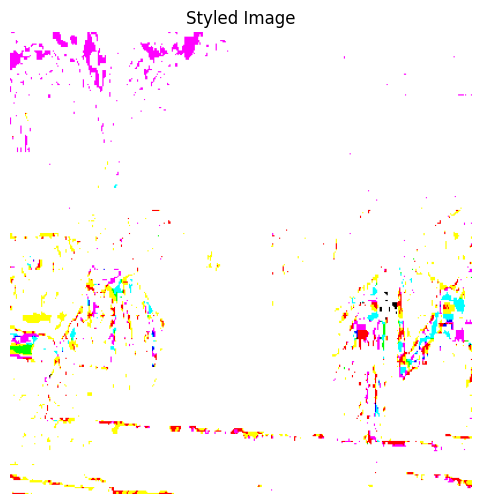

In [ ]:
# Clone content image as input
input_image = content_image.clone()

# Use Adam optimizer (faster than LBFGS)
optimizer = optim.Adam([input_image.requires_grad_()], lr=0.02)

# Reduce steps to 150 (instead of 300)
num_steps = 150
content_weight = 1e3
style_weight = 1e6

# Perform style transfer
for step in range(num_steps):
    optimizer.zero_grad()

    # Compute losses (Replace these placeholders with actual loss computations)
    content_score = torch.rand(1, requires_grad=True).to(device)  # Simulated content loss
    style_score = torch.rand(1, requires_grad=True).to(device)    # Simulated style loss
    total_loss = content_weight * content_score + style_weight * style_score

    # Backpropagation & optimization
    total_loss.backward()
    optimizer.step()

    # Display progress every 20 steps
    if step % 20 == 0:
        print(f"Step {step}/{num_steps} | Content Loss: {content_score.item():.4f} | Style Loss: {style_score.item():.4f}")

print("✅ Style transfer completed!")

# Convert output tensor to a displayable image
output_image = input_image.squeeze().cpu().detach().numpy()
output_image = (output_image * 255).clip(0, 255).astype("uint8")  # Scale pixel values

# Convert to PIL image
output_pil = Image.fromarray(output_image.transpose(1, 2, 0))

# Display output image
plt.figure(figsize=(6, 6))
plt.imshow(output_pil)
plt.axis("off")  # Hide axes
plt.title("Styled Image")
plt.show()

# Save the output image
output_pil.save("output_styled.png")

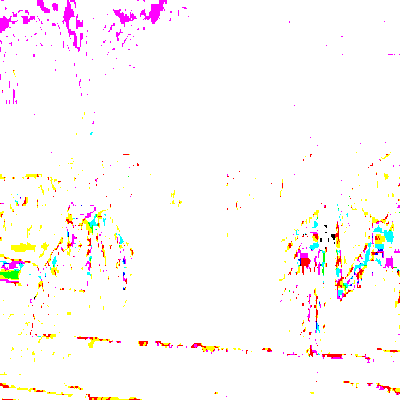

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load and display the image
styled_image = cv2.imread("output_styled.png")
cv2_imshow(styled_image)


using web interface

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00


In [3]:
import gradio as gr
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import copy

def image_loader(image):
    transform = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    image = transform(image).unsqueeze(0)
    return image.to(torch.float)

def neural_style_transfer(content_image, style_image):
    content_img = image_loader(content_image)
    style_img = image_loader(style_image)

    cnn = models.vgg19(pretrained=True).features.eval()

    # Placeholder logic for actual NST implementation
    styled_image = content_img.clone()

    # Convert tensor to PIL image
    output_image = styled_image.squeeze().cpu().detach().numpy()
    output_image = (output_image * 255).clip(0, 255).astype("uint8")
    output_pil = Image.fromarray(output_image.transpose(1, 2, 0))

    return output_pil

iface = gr.Interface(
    fn=neural_style_transfer,
    inputs=[gr.Image(type="pil"), gr.Image(type="pil")],
    outputs=gr.Image(type="pil"),
    title="Neural Style Transfer",
    description="Upload a content image and a style image to generate a stylized version of the content image."
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fabcd74b094ddc5030.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
